In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import serialize_keras_object, deserialize_keras_object
import numpy as np
import matplotlib.pyplot as plt

IMG_H, IMG_W = 28, 28
LATENT_DIM = 2
BATCH_SIZE = 256

@register_keras_serializable()
class Encoder(layers.Layer):
    def __init__(self, latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(16, activation="relu")
        self.z_mean = layers.Dense(latent_dim)
        self.z_logvar = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        self.shape_before_flatten = tf.shape(x)[1:]
        x = self.flatten(x)
        x = self.dense(x)
        return self.z_mean(x), self.z_logvar(x)

    def get_config(self):
        config = super().get_config()
        config.update({"latent_dim": self.z_mean.units})
        return config

@register_keras_serializable()
class Decoder(layers.Layer):
    def __init__(self, shape_before_flattening=(7, 7, 64), **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(np.prod(shape_before_flattening), activation="relu")
        self.reshape = layers.Reshape(shape_before_flattening)
        self.deconv1 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.deconv2 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")
        self.output_layer = layers.Conv2D(1, 3, activation="sigmoid", padding="same")

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        return self.output_layer(x)

    def get_config(self):
        config = super().get_config()
        config.update({"shape_before_flattening": self.reshape.target_shape})
        return config

@register_keras_serializable()
class Sampler(layers.Layer):
    def call(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        return z_mean + tf.exp(0.5 * z_logvar) * epsilon

# ------- Define VAE -------
@register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_logvar = self.encoder(inputs)
        z = self.sampler(z_mean, z_logvar)
        return z_mean, z_logvar, z, self.decoder(z)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_logvar, z, reconstruction = self(data, training=True)
            rec_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar))
            total_loss = rec_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(rec_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def get_config(self):
        return {
        "encoder": serialize_keras_object(self.encoder),
        "decoder": serialize_keras_object(self.decoder)
    }

    @classmethod
    def from_config(cls, config):
        encoder = deserialize_keras_object(config.pop("encoder"))
        decoder = deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)

# ------- Import Data -------
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_all = np.concatenate([x_train, x_test], axis=0)
x_all = np.expand_dims(x_all, -1).astype("float32") / 255

# ------- Train -------
encoder = Encoder(latent_dim=LATENT_DIM)
dummy_input = tf.zeros((1, 28, 28, 1))
_, _ = encoder(dummy_input)
shape_before_flattening = (7, 7, 64)
decoder = Decoder(shape_before_flattening=shape_before_flattening)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(x_all, epochs=20, batch_size=BATCH_SIZE)

# ------- Save -------
vae.save("vae_model.keras")

# ------- Load -------
vae_loaded = keras.models.load_model(
    "vae_model.keras",
    custom_objects={"Encoder": Encoder, "Decoder": Decoder, "Sampler": Sampler, "VAE": VAE}
)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - kl_loss: 1.2352 - reconstruction_loss: 79.0616 - total_loss: 80.2967
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - kl_loss: 1.0888 - reconstruction_loss: 48.9308 - total_loss: 50.0196
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - kl_loss: 1.1870 - reconstruction_loss: 47.3984 - total_loss: 48.5854
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - kl_loss: 1.3451 - reconstruction_loss: 45.5977 - total_loss: 46.9429
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - kl_loss: 2.0737 - reconstruction_loss: 41.0706 - total_loss: 43.1443
Epoch 6/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - kl_loss: 2.5076 - reconstruction_loss: 37.7283 - total_loss: 40.2359
Epoch 7/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - kl_loss: 2.6366 - reconstruction_loss: 36.3821 - total_loss: 39.0188
Epoch 8/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - kl_loss: 2.6882 - reconstruction_loss: 35.6342 - total_loss: 38.322

/Users/heather/myvenv/tensorflow/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/heather/myvenv/tensorflow/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'decoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


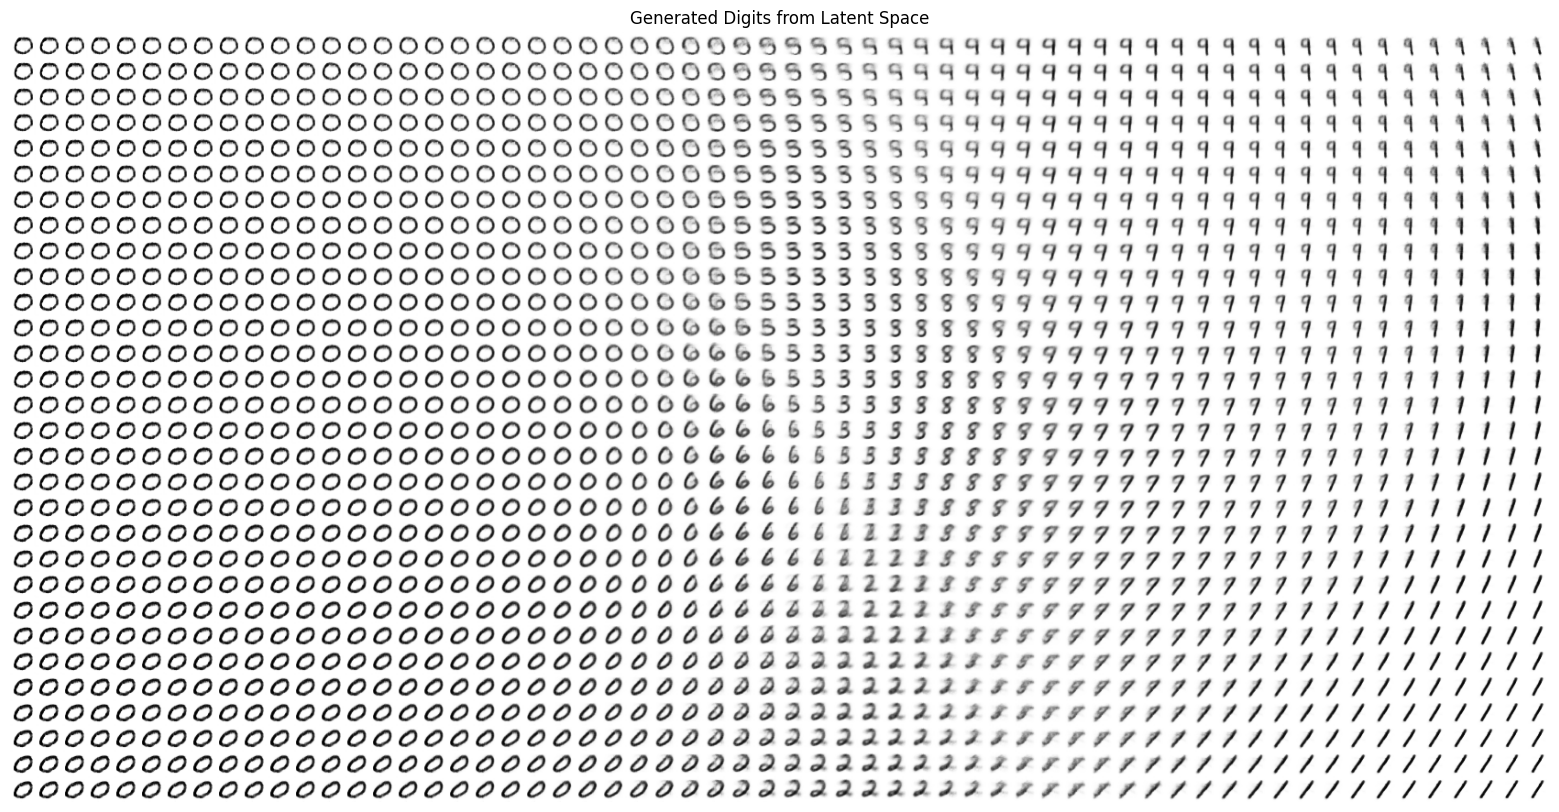

In [12]:
n = 30
digit_size = 28
grid_x = np.linspace(-2, 2, 2 * n)
grid_y = np.linspace(-2, 2, n)

figure = np.zeros((digit_size * n, digit_size * 2 * n)) 

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]], dtype="float32")
        x_decoded = vae_loaded.decoder(z_sample)
        digit = x_decoded[0].numpy().reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size
        ] = digit

plt.figure(figsize=(30, 10))
plt.axis("off")
plt.imshow(1 - figure, cmap="Greys_r")
plt.title("Generated Digits from Latent Space")
plt.show()


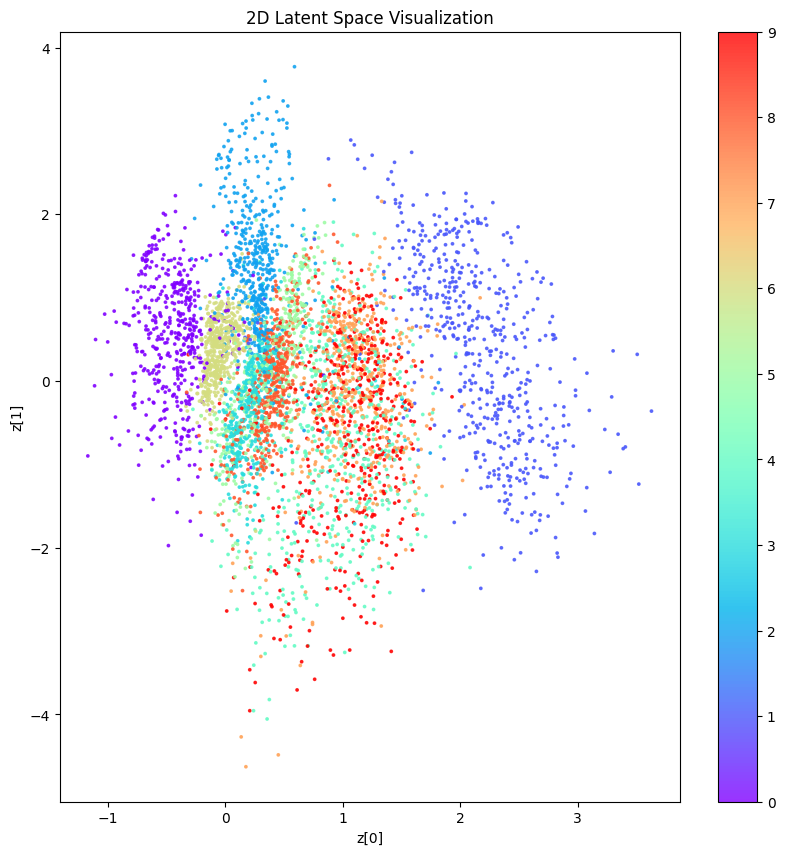

In [15]:
#%% Explore the latent space

# Reload
(_, y_train), (_, y_test) = keras.datasets.mnist.load_data()

n = 5000
z_mean, z_logvar = vae.encoder(x_all[:n]) 
z = Sampler()(z_mean, z_logvar)            # shape: (5000, 2)
y_all = np.concatenate([y_train, y_test], axis=0)

plt.figure(figsize=(10, 10))
plt1 = plt.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=y_all[:n], alpha=0.8, s=3)
plt.colorbar(plt1)
plt.title("2D Latent Space Visualization")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()





/Users/heather/myvenv/tensorflow/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'encoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/heather/myvenv/tensorflow/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'decoder_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2025-04-20 21:21:24.112148: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-20


✅ 模型加载成功！
z_mean shape: (1, 2)
z_logvar shape: (1, 2)
z shape: (1, 2)
Reconstruction shape: (1, 28, 28, 1)


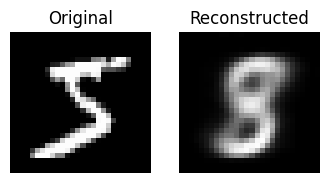

In [2]:
# ✅ check

# Step 1
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import serialize_keras_object, deserialize_keras_object
from keras.saving import register_keras_serializable
import numpy as np
import matplotlib.pyplot as plt

# Step 2

@register_keras_serializable()
class Encoder(layers.Layer):
    def __init__(self, latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(16, activation="relu")
        self.z_mean = layers.Dense(latent_dim)
        self.z_logvar = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.z_mean(x), self.z_logvar(x)

@register_keras_serializable()
class Decoder(layers.Layer):
    def __init__(self, shape_before_flattening=(7, 7, 64), **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(np.prod(shape_before_flattening), activation="relu")
        self.reshape = layers.Reshape(shape_before_flattening)
        self.deconv1 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.deconv2 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")
        self.output_layer = layers.Conv2D(1, 3, activation="sigmoid", padding="same")

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        return self.output_layer(x)

@register_keras_serializable()
class Sampler(layers.Layer):
    def call(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        return z_mean + tf.exp(0.5 * z_logvar) * epsilon

@register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()

    def call(self, inputs):
        z_mean, z_logvar = self.encoder(inputs)
        z = self.sampler(z_mean, z_logvar)
        return z_mean, z_logvar, z, self.decoder(z)

    def get_config(self):
        return {
            "encoder": serialize_keras_object(self.encoder),
            "decoder": serialize_keras_object(self.decoder)
        }

    @classmethod
    def from_config(cls, config):
        encoder = deserialize_keras_object(config.pop("encoder"))
        decoder = deserialize_keras_object(config.pop("decoder"))
        return cls(encoder, decoder, **config)

# Step 3
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_all = np.concatenate([x_train, x_test], axis=0)
x_all = np.expand_dims(x_all, -1).astype("float32") / 255

# Step 4
vae_loaded = keras.models.load_model(
    "vae_model.keras",
    custom_objects={
        "Encoder": Encoder,
        "Decoder": Decoder,
        "Sampler": Sampler,
        "VAE": VAE
    }
)

# Step 5
try:
    sample = x_all[:1]
    z_mean, z_logvar, z, recon = vae_loaded(sample)

    print("\n✅ 模型加载成功！")
    print("z_mean shape:", z_mean.shape)
    print("z_logvar shape:", z_logvar.shape)
    print("z shape:", z.shape)
    print("Reconstruction shape:", recon.shape)

    # 
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(sample[0].squeeze(), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed")
    plt.imshow(recon[0].numpy().squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

except Exception as e:
    print("❌ ：", e)